In [45]:
import matplotlib.pyplot as plt
import jax, optax
import jax.numpy as jnp
import equinox as eqx

# Learning `sinc(x)`

We will be generating a multilayer perceptron (MLP) to use as our deep network to optimize. This uses the `equinox` package, the same package used to generate the MLPs used in the exchange/correlation networks in `xcquinox`.

In [260]:
NODES = 32
DEPTH = 4
SEED = 92017

class sincNet(eqx.Module):
    depth: int
    nodes: int
    seed: int
    net: eqx.nn.MLP
    
    def __init__(self, depth, nodes, seed):
        self.depth = depth
        self.nodes = nodes
        self.seed = seed
        self.net = eqx.nn.MLP(in_size = 1,
                 out_size = 1,
                 depth = self.depth,
                 width_size = self.nodes,
                 activation = jax.nn.gelu,
                 key = jax.random.PRNGKey(self.seed))

    def __call__(self, inp):
        #the network is expecting a single input, so we use jax.vmap to broadcast the calculation 
        # across the input array
        return self.net(inp)

net = sincNet(depth=DEPTH, nodes=NODES, seed=SEED)

We will focus our learning on a symmetric mesh of x-values.

In [261]:
MAGNITUDE = 3
NPTS = 200
inps = jnp.linspace(-MAGNITUDE, MAGNITUDE, num = NPTS, endpoint = True)
refs = jnp.sinc(inps)
grefs = jax.vmap(jax.grad(jnp.sinc))(inps)

Let's see what we're trying to learn. The vertical lines bound the region being learned.

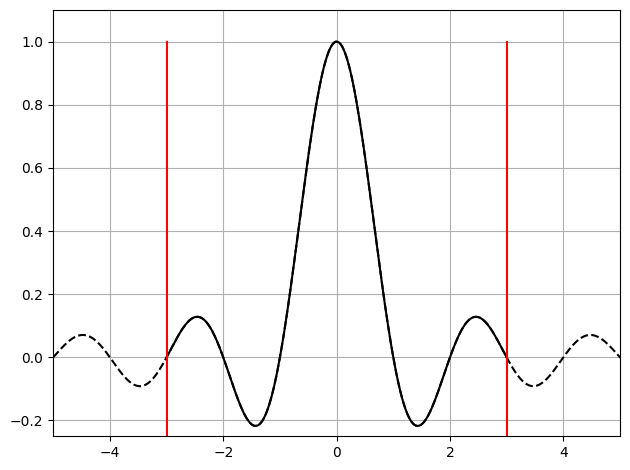

In [262]:
extrax = jnp.linspace(-10, 10, num=1000)
verty = jnp.linspace(-1, 1)
onesy = jnp.ones_like(verty)

plt.plot(extrax, jnp.sinc(extrax), 'k--')
plt.plot(inps, refs, 'k-')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-5, 5)
plt.ylim(-0.25, 1.1)
plt.grid()
plt.tight_layout()

As a descriptive example of how useful the randomly initialized network is, let's see it's output in this range.

In [263]:
#jnp.newaxis just gives the inps array a shape of (NPTS, 1) instead of (NPTS,)
init_preds = jax.vmap(net)(inps[:, jnp.newaxis])

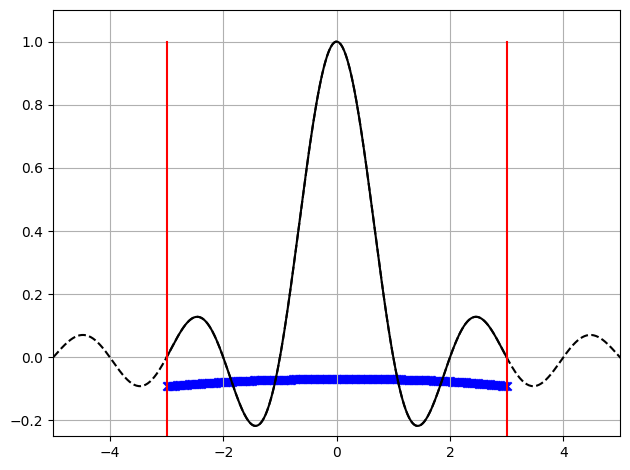

In [264]:
extrax = jnp.linspace(-10, 10, num=1000)
verty = jnp.linspace(-1, 1)
onesy = jnp.ones_like(verty)

plt.plot(extrax, jnp.sinc(extrax), 'k--')
plt.plot(inps, refs, 'k-')
plt.scatter(inps, init_preds, color='b', marker='x')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-5, 5)
plt.ylim(-0.25, 1.1)
plt.grid()
plt.tight_layout()

We will go through the training process using the `equinox` package. Now we build the training loop, within which we place the loss calculation and update function.

In [315]:
def loop(model, inp, ref, optimizer, epochs=1000000, printevery = 2500):
    #define the loss function
    @eqx.filter_value_and_grad
    def compute_loss(model, inp, ref):
        pred = jax.vmap(model)(inp)
        loss = jnp.sqrt(jnp.mean( (pred-ref)**2))
        return loss
    
    #define an update function to optimize the network
    @eqx.filter_jit
    def make_step(model, inp, ref, opt_state):
        loss, grad = compute_loss(model, inp, ref)
        updates, opt_state = optimizer.update(grad, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    losses = []
    for step in range(epochs):
        loss, model, opt_state = make_step(model, inp, ref, opt_state)
        loss = loss.item()
        losses.append(loss)
        if step%printevery == 0:
            print(f'Epoch {step}: Loss = {loss}')

    return model, losses

We use the ADAM optimizer with an initial learning rate as set below, as well as one with an exponential decay schedule to generate two sinc networks to compare.

In [266]:
LR = 0.01
EPOCHS = 100000
DECAYSTART = EPOCHS//10
TRANSITION_STEPS = EPOCHS-DECAYSTART
DECAY_RATE = 0.8
scheduler = optax.exponential_decay(init_value = LR, transition_begin=DECAYSTART,
                                    transition_steps = TRANSITION_STEPS,
                                    decay_rate = DECAY_RATE)
optim = optax.adam(LR)
optimExp = optax.adam(learning_rate = scheduler)

In [267]:
newnet, losses = loop(net, inps[:, jnp.newaxis], refs[:, jnp.newaxis], optim, epochs=EPOCHS)

Epoch 0: Loss = 0.4370814561843872
Epoch 2500: Loss = 0.005187768489122391
Epoch 5000: Loss = 0.004137073177844286
Epoch 7500: Loss = 0.008110249415040016
Epoch 10000: Loss = 0.004347707144916058
Epoch 12500: Loss = 0.003226224333047867
Epoch 15000: Loss = 0.00396863603964448
Epoch 17500: Loss = 0.005361134186387062
Epoch 20000: Loss = 0.0025139502249658108
Epoch 22500: Loss = 0.0039630769751966
Epoch 25000: Loss = 0.0029891326557844877
Epoch 27500: Loss = 0.0028601037338376045
Epoch 30000: Loss = 0.0044568744488060474
Epoch 32500: Loss = 0.0028989387210458517
Epoch 35000: Loss = 0.003093463135883212
Epoch 37500: Loss = 0.0031119694467633963
Epoch 40000: Loss = 0.0024252540897578
Epoch 42500: Loss = 0.0030341888777911663
Epoch 45000: Loss = 0.007393860258162022
Epoch 47500: Loss = 0.0020710821263492107
Epoch 50000: Loss = 0.0032097194343805313
Epoch 52500: Loss = 0.0017051672330126166
Epoch 55000: Loss = 0.002123502781614661
Epoch 57500: Loss = 0.003502929350361228
Epoch 60000: Loss = 

In [268]:
newnetExp, lossesExp = loop(net, inps[:, jnp.newaxis], refs[:, jnp.newaxis], optimExp, epochs=EPOCHS)

Epoch 0: Loss = 0.4370814561843872
Epoch 2500: Loss = 0.005187768489122391
Epoch 5000: Loss = 0.004137073177844286
Epoch 7500: Loss = 0.008110249415040016
Epoch 10000: Loss = 0.004347707144916058
Epoch 12500: Loss = 0.003876074682921171
Epoch 15000: Loss = 0.0022929818369448185
Epoch 17500: Loss = 0.006508479360491037
Epoch 20000: Loss = 0.0038768581580370665
Epoch 22500: Loss = 0.002417445881292224
Epoch 25000: Loss = 0.0029969755560159683
Epoch 27500: Loss = 0.0026181419380009174
Epoch 30000: Loss = 0.0027902103029191494
Epoch 32500: Loss = 0.004179303999990225
Epoch 35000: Loss = 0.0028874126728624105
Epoch 37500: Loss = 0.003804829204455018
Epoch 40000: Loss = 0.003567950101569295
Epoch 42500: Loss = 0.0027153119444847107
Epoch 45000: Loss = 0.0026636498514562845
Epoch 47500: Loss = 0.001990747172385454
Epoch 50000: Loss = 0.00415401253849268
Epoch 52500: Loss = 0.0018654592568054795
Epoch 55000: Loss = 0.002335841068997979
Epoch 57500: Loss = 0.0024168838281184435
Epoch 60000: Los

Just to see what happens, we now feed in `newnet` to the scheduled optimization to see how it may improve.

In [269]:
newnet2, losses2 = loop(newnet, inps[:, jnp.newaxis], refs[:, jnp.newaxis], optimExp, epochs=EPOCHS)

Epoch 0: Loss = 0.001944134826771915
Epoch 2500: Loss = 0.0018578090239316225
Epoch 5000: Loss = 0.0016687982715666294
Epoch 7500: Loss = 0.0022825240157544613
Epoch 10000: Loss = 0.002430311171337962
Epoch 12500: Loss = 0.0011972961947321892
Epoch 15000: Loss = 0.0019415662391111255
Epoch 17500: Loss = 0.0021785260178148746
Epoch 20000: Loss = 0.0015392146306112409
Epoch 22500: Loss = 0.002180397277697921
Epoch 25000: Loss = 0.001940893824212253
Epoch 27500: Loss = 0.0020104884169995785
Epoch 30000: Loss = 0.0016973998863250017
Epoch 32500: Loss = 0.0016752670053392649
Epoch 35000: Loss = 0.0016925438540056348
Epoch 37500: Loss = 0.002210343489423394
Epoch 40000: Loss = 0.0016770950751379132
Epoch 42500: Loss = 0.0011237886501476169
Epoch 45000: Loss = 0.00088243477512151
Epoch 47500: Loss = 0.0014793237205594778
Epoch 50000: Loss = 0.0011830308940261602
Epoch 52500: Loss = 0.001606008387170732
Epoch 55000: Loss = 0.0011903534177690744
Epoch 57500: Loss = 0.001404275419190526
Epoch 60

Now let's see how these do on the training region.

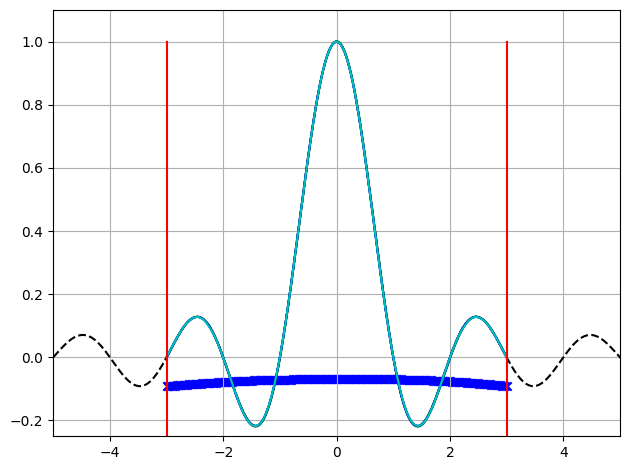

In [270]:
newnet_preds = jax.vmap(newnet)(inps[:, jnp.newaxis])
newnetExp_preds = jax.vmap(newnetExp)(inps[:, jnp.newaxis])
newnet2_preds = jax.vmap(newnet2)(inps[:, jnp.newaxis])

extrax = jnp.linspace(-10, 10, num=1000)
extray = jnp.sinc(extrax)
verty = jnp.linspace(-1, 1)
onesy = jnp.ones_like(verty)

plt.plot(extrax, extray, 'k--')
plt.plot(inps, refs, 'k-')
plt.plot(inps, newnet_preds, 'g-')
plt.plot(inps, newnetExp_preds, 'b-')
plt.plot(inps, newnet2_preds, 'c-')
plt.scatter(inps, init_preds, color='b', marker='x')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-5, 5)
plt.ylim(-0.25, 1.1)
plt.grid()
plt.tight_layout()

It seems well-aligned, so let's plot the absolute deviation from reference for the networks.

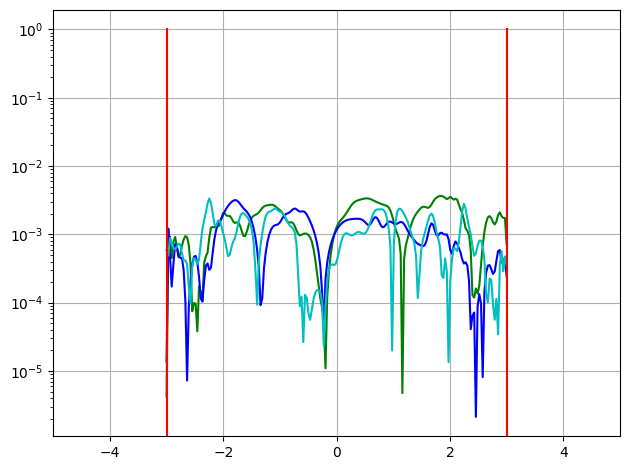

In [271]:
newnet_preds = jax.vmap(newnet)(inps[:, jnp.newaxis])
newnetExp_preds = jax.vmap(newnetExp)(inps[:, jnp.newaxis])
newnet2_preds = jax.vmap(newnet2)(inps[:, jnp.newaxis])

extrax = jnp.linspace(-10, 10, num=1000)
verty = jnp.linspace(-1, 1)
onesy = jnp.ones_like(verty)

plt.plot(inps, jnp.abs(newnet_preds-refs[:, jnp.newaxis]), 'g-')
plt.plot(inps, jnp.abs(newnetExp_preds-refs[:, jnp.newaxis]), 'b-')
plt.plot(inps, jnp.abs(newnet2_preds-refs[:, jnp.newaxis]), 'c-')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-5, 5)
plt.yscale('log')
# plt.ylim(-0.25, 1.1)
plt.grid()
plt.tight_layout()

How about the network's generalization beyond the training region?

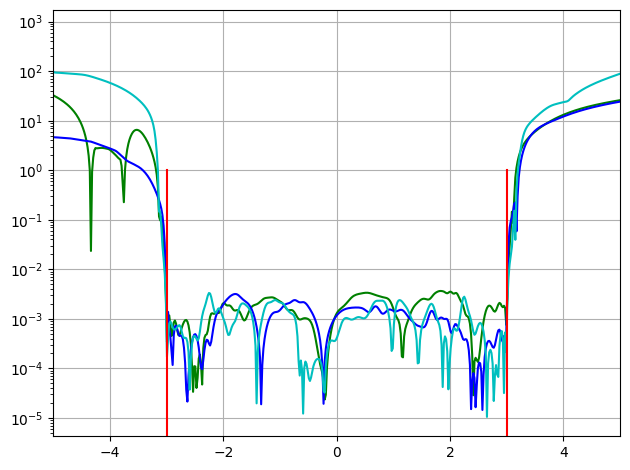

In [272]:
newnet_preds2 = jax.vmap(newnet)(extrax[:, jnp.newaxis])
newnetExp_preds2 = jax.vmap(newnetExp)(extrax[:, jnp.newaxis])
newnet2_preds2 = jax.vmap(newnet2)(extrax[:, jnp.newaxis])

extrax = jnp.linspace(-10, 10, num=1000)
verty = jnp.linspace(-1, 1)
onesy = jnp.ones_like(verty)

plt.plot(extrax, jnp.abs(newnet_preds2-extray[:, jnp.newaxis]), 'g-')
plt.plot(extrax, jnp.abs(newnetExp_preds2-extray[:, jnp.newaxis]), 'b-')
plt.plot(extrax, jnp.abs(newnet2_preds2-extray[:, jnp.newaxis]), 'c-')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-5, 5)
plt.yscale('log')
# plt.ylim(-0.25, 1.1)
plt.grid()
plt.tight_layout()

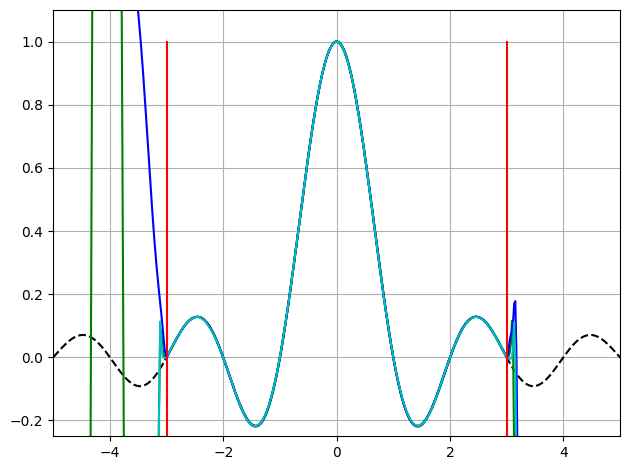

In [273]:
newnet_preds2 = jax.vmap(newnet)(extrax[:, jnp.newaxis])
newnetExp_preds2 = jax.vmap(newnetExp)(extrax[:, jnp.newaxis])
newnet2_preds2 = jax.vmap(newnet2)(extrax[:, jnp.newaxis])

extrax = jnp.linspace(-10, 10, num=1000)
verty = jnp.linspace(-1, 1)
onesy = jnp.ones_like(verty)

plt.plot(extrax, extray, 'k--')
plt.plot(inps, refs, 'k-')
plt.plot(extrax, newnet_preds2, 'g-')
plt.plot(extrax, newnetExp_preds2, 'b-')
plt.plot(extrax, newnet2_preds2, 'c-')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-5, 5)
plt.ylim(-0.25, 1.1)
plt.grid()
plt.tight_layout()

So the network learns the bounded region reasonably well, but does it learn the gradients well or no?

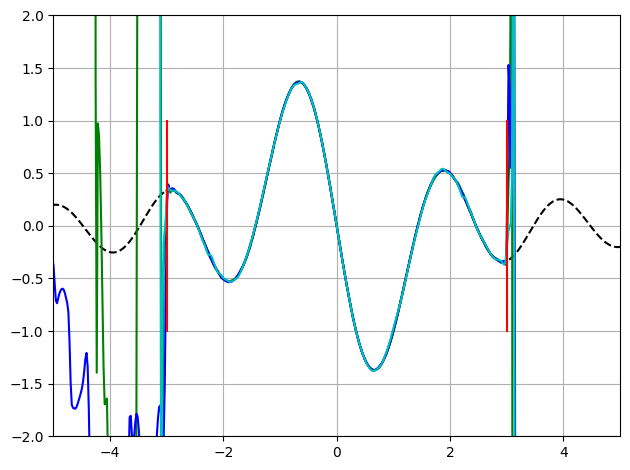

In [298]:
newnet_preds2g = jax.vmap(jax.jacobian(newnet))(extrax[:, jnp.newaxis])[:, 0, 0]
newnetExp_preds2g = jax.vmap(jax.jacobian(newnetExp))(extrax[:, jnp.newaxis])[:, 0, 0]
newnet2_preds2g = jax.vmap(jax.jacobian(newnet2))(extrax[:, jnp.newaxis])[:, 0, 0]

grefs = jax.vmap(jax.grad(jnp.sinc))(inps)
grefsx = jax.vmap(jax.grad(jnp.sinc))(extrax)

extrax = jnp.linspace(-10, 10, num=1000)
verty = jnp.linspace(-1, 1)
onesy = jnp.ones_like(verty)

plt.plot(extrax, grefsx, 'k--')
plt.plot(inps, grefs, 'k-')
plt.plot(extrax, newnet_preds2g, 'g-')
plt.plot(extrax, newnetExp_preds2g, 'b-')
plt.plot(extrax, newnet2_preds2g, 'c-')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-5, 5)
plt.ylim(-2, 2)
plt.grid()
plt.tight_layout()

A cursory glance shows the trained region has well-captured the derivatives, but it certainly doesn't generalize well at all.

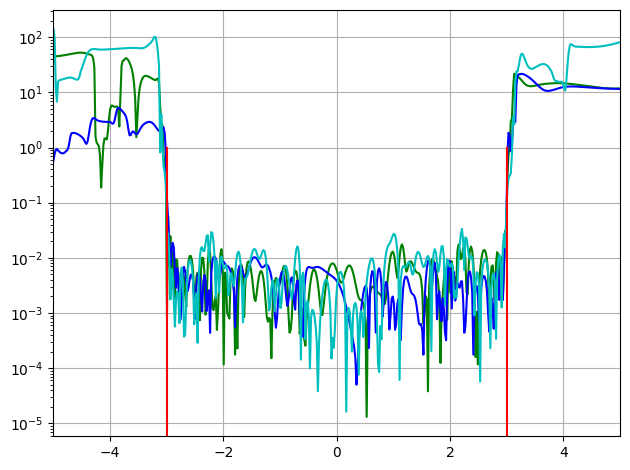

In [301]:
newnet_preds2g = jax.vmap(jax.jacobian(newnet))(extrax[:, jnp.newaxis])[:, 0, 0]
newnetExp_preds2g = jax.vmap(jax.jacobian(newnetExp))(extrax[:, jnp.newaxis])[:, 0, 0]
newnet2_preds2g = jax.vmap(jax.jacobian(newnet2))(extrax[:, jnp.newaxis])[:, 0, 0]

grefs = jax.vmap(jax.grad(jnp.sinc))(inps)
grefsx = jax.vmap(jax.grad(jnp.sinc))(extrax)

extrax = jnp.linspace(-10, 10, num=1000)
verty = jnp.linspace(-1, 1)
onesy = jnp.ones_like(verty)

plt.plot(extrax, abs(newnet_preds2g-grefsx), 'g-')
plt.plot(extrax, abs(newnetExp_preds2g-grefsx), 'b-')
plt.plot(extrax, abs(newnet2_preds2g-grefsx), 'c-')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-5, 5)
# plt.ylim(-2, 2)
plt.yscale('log')
plt.grid()
plt.tight_layout()

# A Constraint
What if now, since we know that $\\sinc(x)\sim x^{-1}$, we enforce such a constraint by enveloping the network output? Will it generalize better? What about if we add in knowledge of the even-symmetry of the function?

In [379]:
class sincNetC(eqx.Module):
    depth: int
    nodes: int
    seed: int
    zoff: float
    net: eqx.nn.MLP
    
    def __init__(self, depth, nodes, seed, zoff=1e-8):
        self.depth = depth
        self.nodes = nodes
        self.seed = seed
        self.zoff = zoff
        self.net = eqx.nn.MLP(in_size = 1,
                 out_size = 1,
                 depth = self.depth,
                 width_size = self.nodes,
                 activation = jax.nn.gelu,
                 key = jax.random.PRNGKey(self.seed))

    def __call__(self, inp):
        #the network is expecting a single input, so we use jax.vmap to broadcast the calculation 
        # across the input array
        #here we envelope the network output with 1/x
        return self.net(inp)/(inp+self.zoff)

class sincNetC2(eqx.Module):
    depth: int
    nodes: int
    seed: int
    zoff: float
    net: eqx.nn.MLP
    
    def __init__(self, depth, nodes, seed, zoff=1e-8):
        self.depth = depth
        self.nodes = nodes
        self.seed = seed
        self.zoff = zoff
        self.net = eqx.nn.MLP(in_size = 1,
                 out_size = 1,
                 depth = self.depth,
                 width_size = self.nodes,
                 activation = jax.nn.gelu,
                 key = jax.random.PRNGKey(self.seed))

    def __call__(self, inp):
        #the network is expecting a single input, so we use jax.vmap to broadcast the calculation 
        # across the input array
        #here we envelope the network output with 1/x
        #as well as enforce the even symmetry: f(-x) = f(x) so just use the absolute value of the input
        return self.net(jnp.abs(inp))/(jnp.abs(inp)+self.zoff)

class sincNetC3(eqx.Module):
    depth: int
    nodes: int
    seed: int
    zoff: float
    net: eqx.nn.MLP
    
    def __init__(self, depth, nodes, seed, zoff=1e-8):
        self.depth = depth
        self.nodes = nodes
        self.seed = seed
        self.zoff = zoff
        self.net = eqx.nn.MLP(in_size = 1,
                 out_size = 1,
                 depth = self.depth,
                 width_size = self.nodes,
                 activation = jax.nn.gelu,
                 key = jax.random.PRNGKey(self.seed))

    def __call__(self, inp):
        #the network is expecting a single input, so we use jax.vmap to broadcast the calculation 
        # across the input array
        #here we envelope the network output with 1/x
        #as well as enforce the even symmetry: f(-x) = f(x) so just use the absolute value of the input
        #as well as f(0) = 1
        def false_func(inp):
            return jnp.sinc(inp)
        def true_func(inp):
            return self.net(jnp.abs(inp))/(jnp.abs(inp)+self.zoff)
        #this tests the input value -- if zero, the input is sent to the false_func
        result = jax.lax.cond(inp[0], true_func, false_func, inp) 
        return result


netc = sincNetC(depth=DEPTH, nodes=NODES, seed=SEED)
netc2 = sincNetC2(depth=DEPTH, nodes=NODES, seed=SEED)
netc3 = sincNetC3(depth=DEPTH, nodes=NODES, seed=SEED)

In [380]:
MAGNITUDE = 3
NPTS = 200
inps = jnp.linspace(-MAGNITUDE, MAGNITUDE, num = NPTS, endpoint = True)
refs = jnp.sinc(inps)
grefs = jax.vmap(jax.grad(jnp.sinc))(inps)

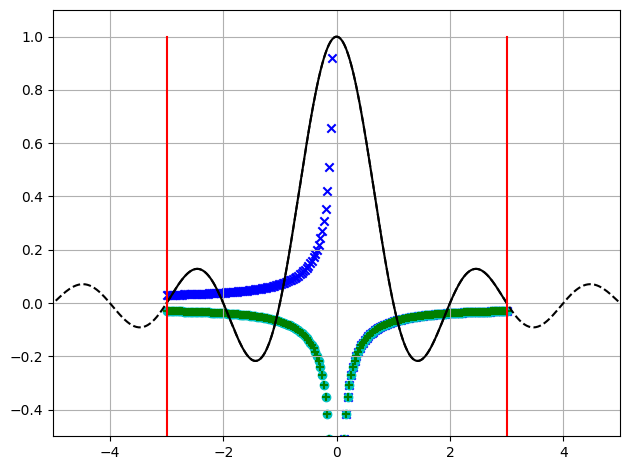

In [381]:
#jnp.newaxis just gives the inps array a shape of (NPTS, 1) instead of (NPTS,)
init_predsc = jax.vmap(netc)(inps[:, jnp.newaxis])
init_predsc2 = jax.vmap(netc2)(inps[:, jnp.newaxis])
#can't vmap across a jax.lax.cond for some reason
init_predsc3 = [netc3(x) for x in inps[:, jnp.newaxis]]
extrax = jnp.linspace(-10, 10, num=1000)
verty = jnp.linspace(-1, 1)
onesy = jnp.ones_like(verty)

plt.plot(extrax, jnp.sinc(extrax), 'k--')
plt.plot(inps, refs, 'k-')
plt.scatter(inps, init_predsc, color='b', marker='x')
plt.scatter(inps, init_predsc2, color='c', marker='o')
plt.scatter(inps, init_predsc2, color='g', marker='+')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-5, 5)
plt.ylim(-0.5, 1.1)
plt.grid()
plt.tight_layout()

For brevity, we will just train one of each new type of network now.

In [383]:
LR = 0.01
EPOCHS = 100000
DECAYSTART = EPOCHS//10
TRANSITION_STEPS = EPOCHS-DECAYSTART
DECAY_RATE = 0.8
scheduler = optax.exponential_decay(init_value = LR, transition_begin=DECAYSTART,
                                    transition_steps = TRANSITION_STEPS,
                                    decay_rate = DECAY_RATE)
optimExp = optax.adam(learning_rate = scheduler)
newnetc, lossesc = loop(netc, inps[:, jnp.newaxis], refs[:, jnp.newaxis], optimExp, epochs=EPOCHS)
newnetc2, lossesc2 = loop(netc2, inps[:, jnp.newaxis], refs[:, jnp.newaxis], optimExp, epochs=EPOCHS)
newnetc3, lossesc3 = loop(netc3, inps[:, jnp.newaxis], refs[:, jnp.newaxis], optimExp, epochs=EPOCHS)

Epoch 0: Loss = 0.6488654017448425
Epoch 2500: Loss = 0.007594567723572254
Epoch 5000: Loss = 0.015371250919997692
Epoch 7500: Loss = 0.008835963904857635
Epoch 10000: Loss = 0.01261882483959198
Epoch 12500: Loss = 0.013072796165943146
Epoch 15000: Loss = 0.01015186496078968
Epoch 17500: Loss = 0.010013256222009659
Epoch 20000: Loss = 0.007535360753536224
Epoch 22500: Loss = 0.007998243905603886
Epoch 25000: Loss = 0.007855739444494247
Epoch 27500: Loss = 0.005258316174149513
Epoch 30000: Loss = 0.011038212105631828
Epoch 32500: Loss = 0.005985989701002836
Epoch 35000: Loss = 0.002148690866306424
Epoch 37500: Loss = 0.0072779241017997265
Epoch 40000: Loss = 0.005075214430689812
Epoch 42500: Loss = 0.010896028950810432
Epoch 45000: Loss = 0.008043164387345314
Epoch 47500: Loss = 0.007729952223598957
Epoch 50000: Loss = 0.00745844841003418
Epoch 52500: Loss = 0.00933029968291521
Epoch 55000: Loss = 0.007317802403122187
Epoch 57500: Loss = 0.007175716105848551
Epoch 60000: Loss = 0.006635

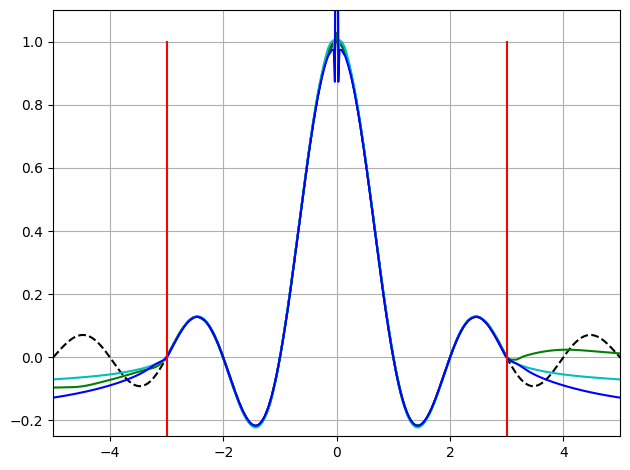

In [385]:
newnetc_preds = jax.vmap(newnetc)(extrax[:, jnp.newaxis])
newnetc2_preds = jax.vmap(newnetc2)(extrax[:, jnp.newaxis])
newnetc3_preds = [newnetc3(x) for x in extrax[:, jnp.newaxis]]

extrax = jnp.linspace(-10, 10, num=1000)
verty = jnp.linspace(-1, 1)
onesy = jnp.ones_like(verty)

plt.plot(extrax, extray, 'k--')
plt.plot(inps, refs, 'k-')
plt.plot(extrax, newnetc_preds, 'g-')
plt.plot(extrax, newnetc2_preds, 'c-')
plt.plot(extrax, newnetc3_preds, 'b-')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-5, 5)
plt.ylim(-0.25, 1.1)
plt.grid()
plt.tight_layout()

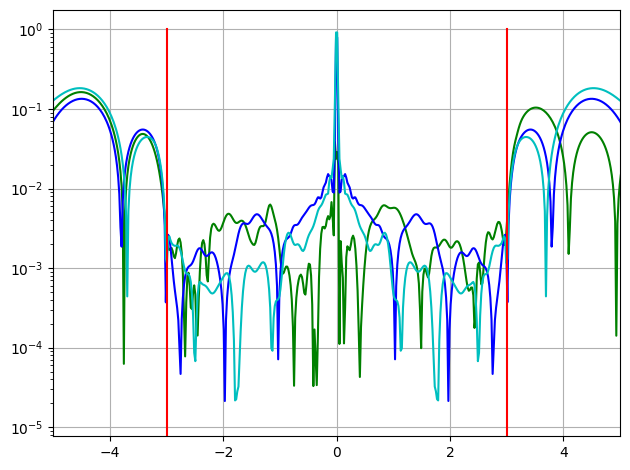

In [387]:
plt.plot(extrax, jnp.abs(newnetc_preds-extray[:, jnp.newaxis]), 'g-')
plt.plot(extrax, jnp.abs(newnetc2_preds-extray[:, jnp.newaxis]), 'b-')
plt.plot(extrax, jnp.abs(jnp.array(newnetc3_preds)-extray[:, jnp.newaxis]), 'c-')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-5, 5)
plt.yscale('log')
# plt.ylim(-0.25, 1.1)
plt.grid()
plt.tight_layout()

So the constraints bring down the generalization error in the outer regions.

In [388]:
newnetc_predsg = jax.vmap(jax.jacobian(newnetc))(extrax[:, jnp.newaxis])[:, 0, 0]
newnetc2_predsg = jax.vmap(jax.jacobian(newnetc2))(extrax[:, jnp.newaxis])[:, 0, 0]
newnetc3_predsg = jax.vmap(jax.jacobian(newnetc3))(extrax[:, jnp.newaxis])[:, 0, 0]


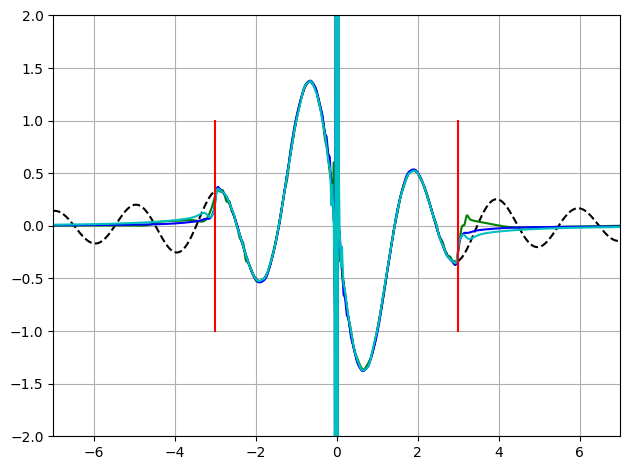

In [391]:
plt.plot(extrax, grefsx, 'k--')
plt.plot(inps, grefs, 'k-')
plt.plot(extrax, newnetc_predsg, 'g-')
plt.plot(extrax, newnetc2_predsg, 'b-')
plt.plot(extrax, newnetc3_predsg, 'c-')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-7, 7)
plt.ylim(-2, 2)
plt.grid()
plt.tight_layout()

Now we see, however, that the gradients in the regions beyond the bounded training region are much "better," despite still not being that great.

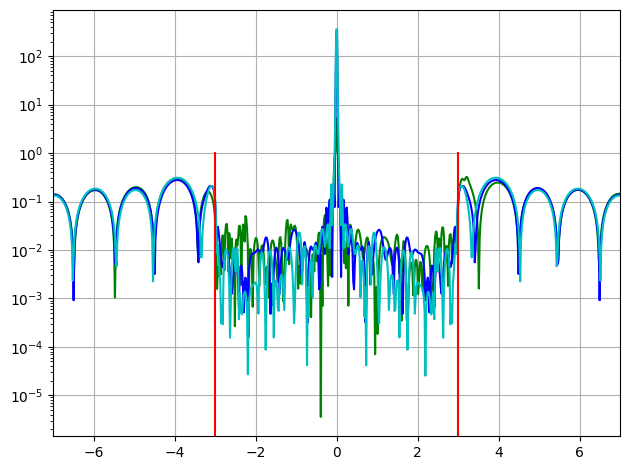

In [396]:
plt.plot(extrax, abs(newnetc_predsg-grefsx), 'g-')
plt.plot(extrax, abs(newnetc2_predsg-grefsx), 'b-')
plt.plot(extrax, abs(newnetc3_predsg-grefsx), 'c-')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-7, 7)
# plt.ylim(-2, 2)
plt.yscale('log')
plt.grid()
plt.tight_layout()

So while the constraints (via the way we enforced them) give worse results for some regions of the bounded training region, the generalization extends to the outer regions in a much more accurate manner.